In [1]:
import pandas as pd
import numpy as np
import os
import saliency.core as saliency
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import PIL.Image

from tensorflow import keras
from tensorflow import convert_to_tensor, GradientTape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, Dense, Conv2D, Dropout, Flatten, MaxPool2D, ReLU
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.applications.efficientnet import EfficientNetB7, preprocess_input, decode_predictions
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, Huber

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
PATH_TO_DATA = 'C:/Users/gaelp/Documents/Projet_DataScientest/data/raw/annotated_regions/'

In [3]:
df = pd.read_csv('C:/Users/gaelp/Documents/Projet_DataScientest/data/raw/label_df.csv')
df.head()

,filename,binary_class,annotation_class
0,C01_B003_S01_0.jpeg,1,1
1,C01_B003_S01_1.jpeg,1,1
2,C01_B003_S01_2.jpeg,1,1
3,C01_B003_S01_3.jpeg,1,1
4,C01_B008_S01_0.jpeg,0,0


In [4]:
df['filename'] = PATH_TO_DATA + df['filename']
df['class'] = df['annotation_class'].astype('string')
df = df[['filename', 'class']]

In [5]:
df_train=df.sample(frac=0.80, random_state=21).copy()
df_test=df.drop(df_train.index).copy()

In [6]:
train_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                          #rescale=1 / 255.0,
                                          rotation_range=90,
                                          width_shift_range=0.1, 
                                          height_shift_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          validation_split=0.2,
                                          fill_mode = "constant",
                                          cval=255)

test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_data_generator.flow_from_dataframe(df_train, 
                                                           class_mode="sparse",
                                                           subset="training"                                                         
                                                          )

validation_generator = train_data_generator.flow_from_dataframe(df_train, 
                                                           class_mode="sparse",
                                                           subset="validation"                                                            
                                                          )

test_generator = test_data_generator.flow_from_dataframe(df_test,
                                                         batch_size=1,
                                                         class_mode="sparse",
                                                         shuffle=False,
                                                    )

Found 3793 validated image filenames belonging to 4 classes.
Found 948 validated image filenames belonging to 4 classes.
Found 1185 validated image filenames belonging to 4 classes.


In [7]:
len_train = 3793
len_val = 948

In [10]:
IMAGE_SHAPE = (256, 256, 3)
batch_size = 16
kernel_size = (5, 5)
filters = (16, 16, 16) #(32, 64, 128)
drop_prob_conv = 0.3
drop_prob_dense = 0.3

model = Sequential()

model.add(Conv2D(filters[0], kernel_size, padding="same", kernel_initializer=he_normal(), input_shape=IMAGE_SHAPE))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(filters[0], kernel_size, padding="same", kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool2D())
model.add(Dropout(drop_prob_conv))

model.add(Conv2D(filters[1], kernel_size, padding="same", kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(filters[1], kernel_size, padding="same", kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool2D())
model.add(Dropout(drop_prob_conv))

model.add(Conv2D(filters[2], kernel_size, padding="same", kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(filters[2], kernel_size, padding="same", kernel_initializer=he_normal(), name="last_conv_layer"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool2D())
model.add(Dropout(drop_prob_conv))

model.add(Flatten())
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(drop_prob_dense))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(drop_prob_dense))
model.add(Dense(4, activation="softmax"))

model.compile(Adam(0.01), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [9]:
lr_decay_params = {
    "monitor": "val_accuracy",
    "factor": 0.5,
    "patience": 1,
    "min_lr": 1e-5
}
lr_decay = ReduceLROnPlateau(**lr_decay_params)

early_stopping = EarlyStopping(monitor="val_accuracy", patience=3, verbose=1)

fit_params = {
    "steps_per_epoch": len_train // batch_size,
    "epochs": 10,
    "verbose": 1,
    "validation_data": validation_generator,
    "validation_steps": len_val,
    "callbacks": [lr_decay, early_stopping]
}
print("Training the model...")
model.fit(train_generator,
         epochs=20, 
         validation_data=validation_generator, 
         callbacks=[lr_decay]
         )
print("Done!")

Training the model...
Epoch 1/20
119/119 [==============================] - 115s 893ms/step - loss: 1.4991 - accuracy: 0.3591 - val_loss: 18.2694 - val_accuracy: 0.2352
Epoch 2/20
119/119 [==============================] - 102s 861ms/step - loss: 1.3246 - accuracy: 0.4197 - val_loss: 25.0112 - val_accuracy: 0.2289
Epoch 3/20
119/119 [==============================] - 103s 860ms/step - loss: 1.2434 - accuracy: 0.4548 - val_loss: 1.7009 - val_accuracy: 0.2437
Epoch 4/20
119/119 [==============================] - 103s 863ms/step - loss: 1.2305 - accuracy: 0.4680 - val_loss: 8.9704 - val_accuracy: 0.2289
Epoch 5/20
119/119 [==============================] - 103s 863ms/step - loss: 1.1884 - accuracy: 0.4727 - val_loss: 1.5364 - val_accuracy: 0.2658
Epoch 6/20
 20/119 [====>.........................] - ETA: 1:05 - loss: 1.1675 - accuracy: 0.4800

ResourceExhaustedError:  OOM when allocating tensor with shape[65536,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/sequential/dense/MatMul_1 (defined at \AppData\Local\Temp\ipykernel_19312\2849404926.py:20) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_2452]

Function call stack:
train_function


In [ ]:
model.save('C:/Users/gaelp/Documents/Projet_DataScientest/CustomModel.h5')

In [10]:
import tensorflow
# Boilerplate methods.
def ShowImage(im, title='', ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    plt.imshow(im)
    plt.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')

    plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.title(title)

def ShowHeatMap(im, title, ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    plt.imshow(im, cmap='inferno')
    plt.title(title)

def LoadImage(file_path):
    im = PIL.Image.open(file_path)
    im = im.resize((256,256))
    im = np.asarray(im)
    return im

def PreprocessImage(im):
    im = tensorflow.keras.applications.efficientnet.preprocess_input(im)
    return im

In [11]:
class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx =  call_model_args[class_idx_str]
    images = convert_to_tensor(images)
    with GradientTape() as tape:
        if expected_keys==[saliency.base.INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)
            #_, output_layer = imported_model(images)
            output_layer = imported_model.predict(np.array([im]))
            output_layer = output_layer[:,target_class_idx]
            gradients = tensorflow.TensorArray(tape.gradient(output_layer, images))
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv_layer, output_layer = model(images)
            gradients = tensorflow.TensorArray(tape.gradient(output_layer, conv_layer))
            return {saliency.base.CONVOLUTION_LAYER_VALUES: conv_layer,
                    saliency.base.CONVOLUTION_OUTPUT_GRADIENTS: gradients}

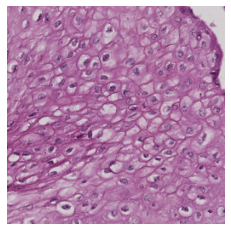

In [12]:
# Load the image
test_img = 'C:/Users/gaelp/Documents/Projet_DataScientest/data/raw/annotated_regions/C01_B003_S01_0.jpeg'
im_orig = LoadImage(test_img)
im = PreprocessImage(im_orig)

# Show the image
ShowImage(im_orig)

# Essais N°3

In [22]:
last_conv_layer_name = "last_conv_layer"
img_path = 'C:/Users/gaelp/Documents/Projet_DataScientest/data/raw/annotated_regions/C01_B003_S01_0.jpeg'

In [26]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tensorflow.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tensorflow.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tensorflow.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tensorflow.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tensorflow.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tensorflow.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tensorflow.newaxis]
    heatmap = tensorflow.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tensorflow.maximum(heatmap, 0) / tensorflow.math.reduce_max(heatmap)
    return heatmap.numpy()

In [27]:
img_array = preprocess_input(get_img_array(img_path, size=(256, 256)))

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", np.argmax(preds[0]))

Predicted: 3


In [ ]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.colorbar(orientation="vertical")
plt.show()

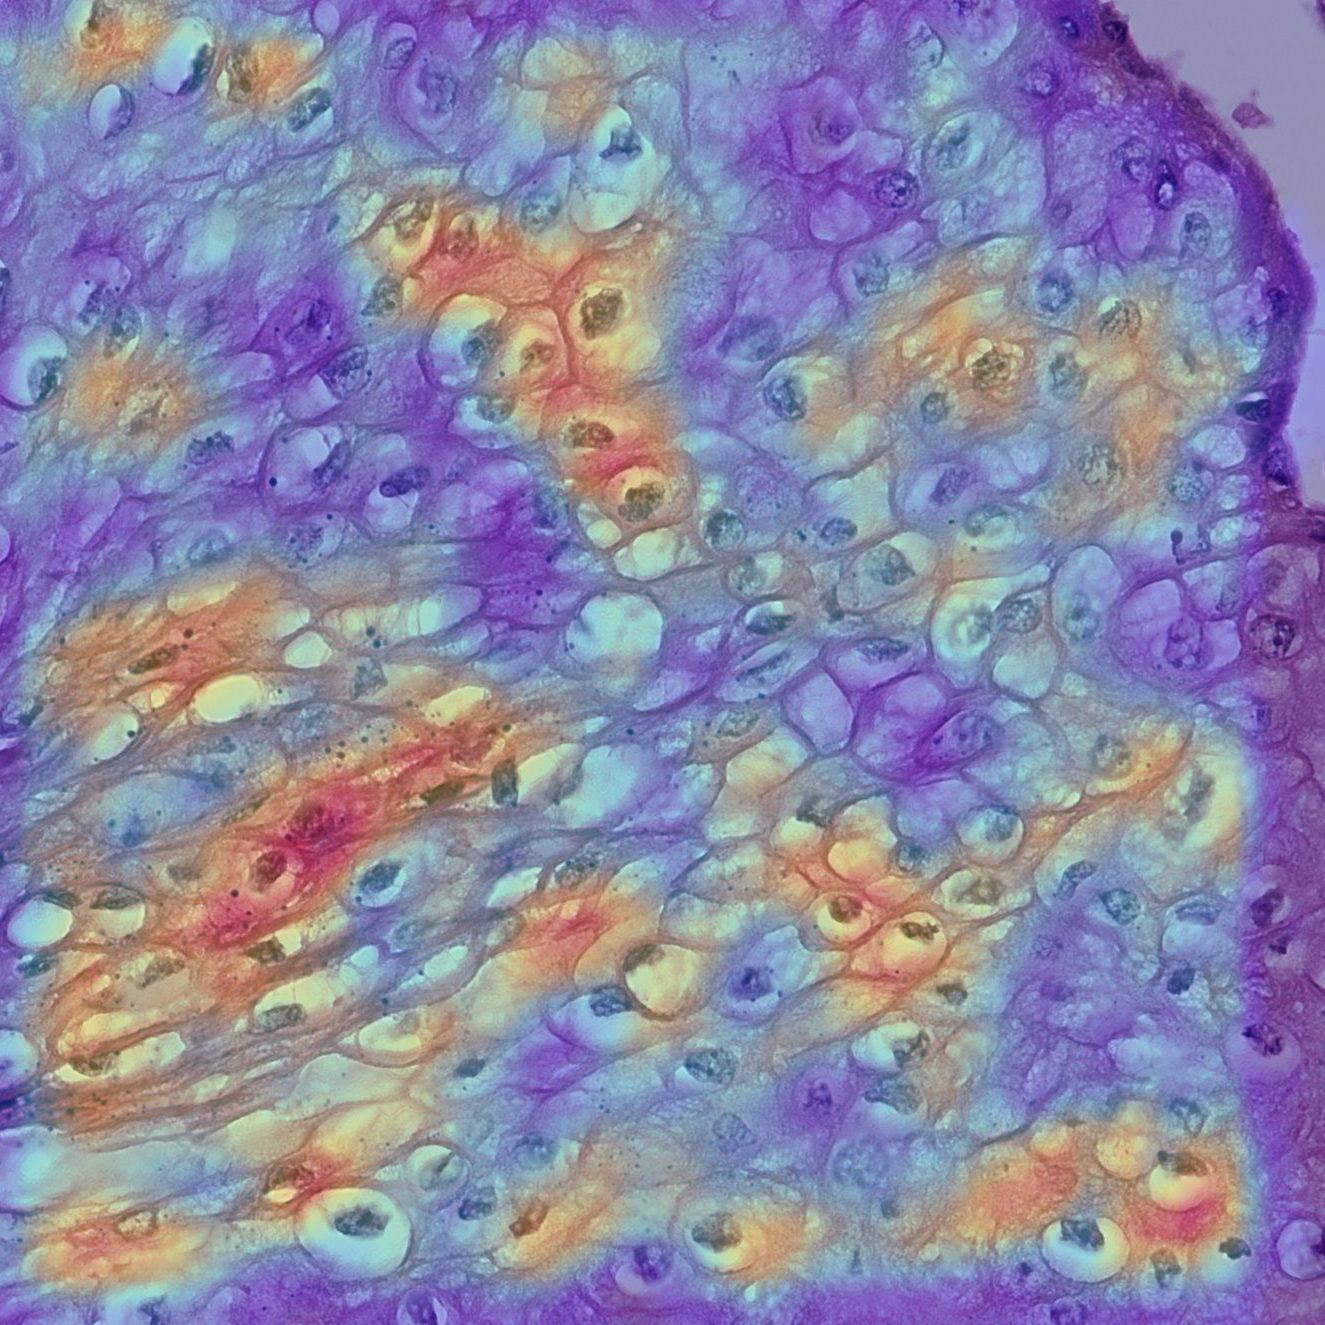

In [31]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tensorflow.keras.preprocessing.image.load_img(img_path)
    img = tensorflow.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tensorflow.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tensorflow.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tensorflow.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)
